# Introduction to the project

Analyze BBC news articles and cluster/classify them using unsupervised learning techiniques and compare the performance with at least one supervised learning model.

## Transfering the data from GitHub to Colab


In [ ]:
!rm -rf /content/bbc_news_dtsa_5510
!rm -rf /content/tmp_data
!git clone https://github.com/rat-sparebank1/bbc_news_dtsa_5510.git

Cloning into 'bbc_news_dtsa_5510'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (13/13), 1.85 MiB | 18.04 MiB/s, done.


In [ ]:
!unzip -q bbc_news_dtsa_5510/data/learn-ai-bbc.zip -d /content/tmp_data

## Importing train and test data and read it in as pandas dataframes

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering, KMeans

In [ ]:
test = pd.read_csv('tmp_data/BBC News Test.csv')
train = pd.read_csv('tmp_data/BBC News Train.csv')

## EDA - Make some initial description of the datasets

In [ ]:
test.info()
print(test.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance family feud heats up the ongo...
4       1020  boro suffer morrison injury blow middlesbrough...


In [ ]:
train.info()
print(train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business


In [ ]:
print("number of articles: ", len(train.ArticleId))
print(train.Category.value_counts())

number of articles:  1490
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64


(array([336.,   0., 261.,   0.,   0., 274.,   0., 346.,   0., 273.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

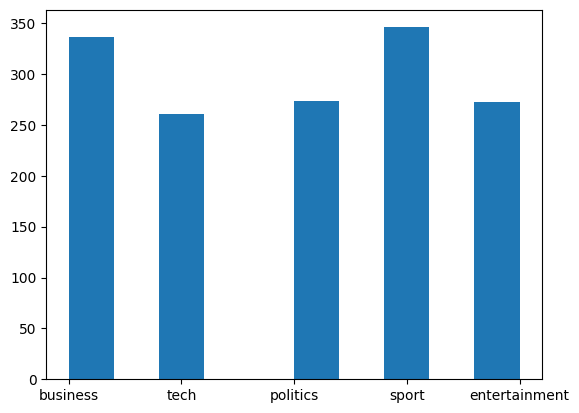

In [ ]:
plt.hist(train.Category)

Trying wordclould to compare clouds between categories

In [ ]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/

def generate_wordcloud(df_column):
  comment_words = ''
  stopwords = set(STOPWORDS)
  additional_stopwords = ["said", "will", "s", "us", "year"]
  for word in additional_stopwords:
    stopwords.add(word)

  for val in df_column:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

  # plot the WordCloud image
  plt.figure(figsize = (4, 4), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

  plt.show()

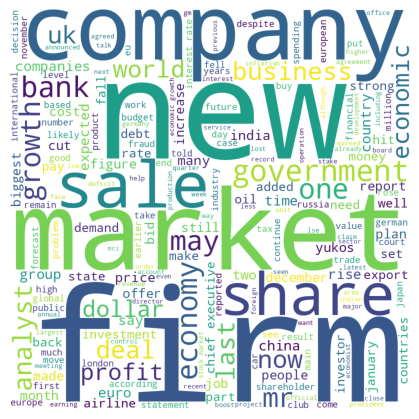

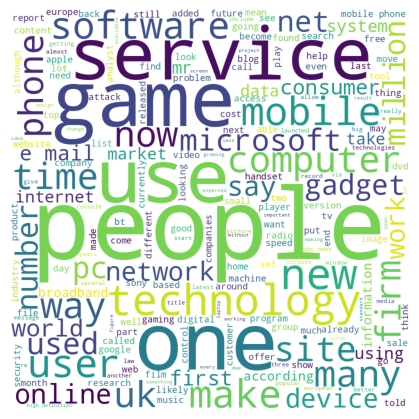

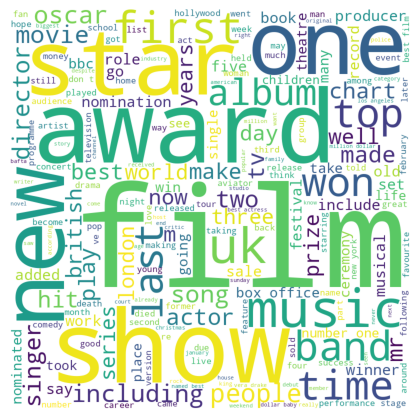

In [ ]:
business_art = train.loc[train.Category == 'business', 'Text']
tech_art = train.loc[train.Category == 'tech', 'Text']
entertainment_art = train.loc[train.Category == 'entertainment', 'Text']

generate_wordcloud(business_art)
generate_wordcloud(tech_art)
generate_wordcloud(entertainment_art)

## Tokenize and vectorize text
I used this example from Scikit Learn:
https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#

In [ ]:
# https://stackoverflow.com/questions/11902665/top-values-from-dictionary
vect = TfidfVectorizer()
tf_vect = vect.fit_transform(train.Text)

print("tfidf matrix shape: ", tf_vect.shape)

tfidf matrix shape:  (1490, 24746)


## Build a model and try to cluster the articles using the same number of categories

In [ ]:
agg_cluster = AgglomerativeClustering(n_clusters=5)
agg_cluster.fit_predict(tf_vect.toarray())
print(agg_cluster.labels_)

[2 2 3 ... 2 3 3]


In [ ]:
# Using permutation method from the lab from Week 2 since we know the groundtruth

def label_permute_compare(ytdf,yp,n=5):
    unique_labels_string = ytdf.Category.unique()
    pred_labels = yp
    permutations = list(itertools.permutations(range(n)))
    max_equal_labels = 0
    max_dict = {}
    max_perm = None
    for perm in permutations:
        dictionary = make_dict(unique_labels_string, perm)
        true_labels = ytdf.Category.replace(dictionary)
        equal_labels = np.sum(true_labels == pred_labels)
        if equal_labels > max_equal_labels:
            max_perm = perm
            max_equal_labels = equal_labels
            max_dict = dictionary
    accuracy = max_equal_labels/len(true_labels)
    return max_perm, max_dict, accuracy

def make_dict(labels_string, perm):
    label_dict = {}
    for string_label, perm_label in zip(labels_string, perm):
        label_dict[string_label] = perm_label
    return label_dict


labelorder, dictionary, acc = label_permute_compare(train, agg_cluster.labels_)
print(dictionary, acc)

{'business': 2, 'tech': 3, 'politics': 1, 'sport': 0, 'entertainment': 4} 0.7429530201342281


In [ ]:
# Lets try to find better parameters
distance_metrics = ['euclidean', 'manhattan']
linkages = ['complete', 'average', 'single', 'ward']
accuracies = []
tf_matrix = tf_vect.toarray()
for linkage in linkages:
    for distance in distance_metrics:
        try:
          model_tmp = AgglomerativeClustering(n_clusters=5, metric=distance, linkage=linkage)
          model_tmp.fit(tf_matrix)
          labelorder_tmp, dict_tmp, acc_tmp = label_permute_compare(train, model_tmp.labels_)
          accuracies.append((acc_tmp, distance, linkage))
        except Exception as e:
          print(e)
accuracies.sort(key = lambda i:i[0], reverse = True)
print(accuracies[0])

manhattan was provided as metric. Ward can only work with euclidean distances.
(0.7429530201342281, 'euclidean', 'ward')


In [ ]:
# Lets try with KMeans
kmeans_model = KMeans(n_clusters=5)
kmeans_model.fit(tf_vect.toarray())
labelorder, dictionary, acc = label_permute_compare(train, kmeans_model.labels_)
print(dictionary, acc)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


{'business': 0, 'tech': 3, 'politics': 2, 'sport': 4, 'entertainment': 1} 0.8167785234899329


## Comparing using supervised learning

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train.Category)
X = train.Text

# split dataset train since dataset test does not have Category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfid_vect = TfidfVectorizer()
X_train_vect = tfid_vect.fit_transform(X_train)
X_test_vect = tfid_vect.transform(X_test)

# Using K-Nearest Neighbor classifier with k = 3
k = 4
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train_vect, y_train)
y_pred = knn_classifier.predict(X_test_vect)
true_positives = y_pred == y_test
acc = np.sum(true_positives)/len(y_test)
print(acc)


0.9328859060402684


## Comparison Supervised and Non-Supervised methods:

I used two different non-supervised methods:
For Agglomerative Clustering (that is a hierarchical clustering method), achieved an accuracy of 0.74 using euclidian distance.

For K-means with 5 clusters (since we have 5 catergories), the accuracy was between 0.71 and 0.81 (K-means clustering is dependent on initial conditions)


I used only K-Nearest Neighbor as the supervised method, and the accuracy was 0.93 (using 4 nearest neighbors)

## Conclusions:
Analyzing text requires tokenizing it and producing vectors.
Tfid vectorizer can do this for us at the same time giving more weight to the words that are not very common and reducing the words that are very frequent.

I could have used different methods to reduce dimensionality since the matrices produced when tokenizing/vectorizing have a high number of dimension and they are sparse.
Some reducing techniques that I could try could be PCA or using lists with stopwords.

The supervised learning made better predictions than the non-supervised learning methods. This may be intuitive since training a model and giving already information about the number of clusters and which element belongs to which category is additional and useful information